In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx
import networkx.algorithms.community as nxcom
import community
from collections import Counter
import pickle

In [3]:
num_datasets_per_comparison = {
'ATB_v_LTBI': 16,
'ATB_v_HC' : 15,
'ATB_v_OD': 10,
'LTBI_v_HC': 9}

#### set the *q-value* threshold & comparison

In [4]:
qval_thresh = 0.05

In [5]:
comparison_X = 'ATB_v_HC'

#### set parameters for plotting

In [6]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

#### specify directory where differential gene data is stored

In [7]:
#use this path for personal computer
#diff_exp_data_dir = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for Gates MRI computer
#diff_exp_data_dir = "/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for O2 computing cluster
diff_exp_data_dir = "/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#### specify directory for pickling objects

In [8]:
#use this path for O2 computing cluster
pickled_objects_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Pickled Files/'

### *Function* for visualizing distribution of edge weights from pooled (significant) logFC changes across datasets

In [8]:
def plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, plot_title, linecolor):
    
    #convert Counter dict to series
    edge_weight_distr_series = pd.Series(edge_weight_distr_counter_dict).sort_index()
    
    #get the keys & values from Counter dict (with Edge Weight distr)
    edge_weight_values = edge_weight_distr_series.index
    edge_weight_count = edge_weight_distr_series.values
    edge_weight_count_norm = np.array(edge_weight_count) / float(np.sum(edge_weight_count)) #normalize counts
    
    ax.bar(edge_weight_values , edge_weight_count_norm, color = 'white' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index <= -3] , edge_weight_count_norm[edge_weight_distr_series.index <= -3], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index >= 3] , edge_weight_count_norm[edge_weight_distr_series.index >= 3], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.plot(edge_weight_values , edge_weight_count_norm, color = linecolor , linewidth = 2.5)
    
    # calculate the number of the edges that had weight <= -3
    negative_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index <= -3].sum()
    
    # calculate the number of the edges that had weight >= 3
    positive_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index >= 3].sum()

    ax.set_title(plot_title, fontsize = 12, color = 'k')
    ax.set_ylabel('Proportion of Edges', fontsize = 12, color = 'k')
    ax.set_xlabel(f'Edge Weights \n (Num Edges <= -3: {negative_edge_weights_for_network}) \n (Num Edges >= 3: {positive_edge_weights_for_network})' , fontsize = 12, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
    for axis in [ax.yaxis]:
        axis.set_major_formatter(FormatStrFormatter('%.5f'))
        
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

## Compute Edges (and corresponding weights) from pooled logFC matrix

In [10]:
logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'

# read in CSV file with significant logFC changes for genes between comparison X samples collected from various datasets
diff_gene_exp_df = pd.read_csv(diff_exp_data_dir + logFC_table_filename).set_index('Unnamed: 0')
diff_gene_exp_df.rename_axis('gene' , inplace = True)

# Construct simplified matrix of logFC direction from DataFrame with significant logFC changes across all analyses by converting values:
# +1 if logFC > 0
#  0 if logFC = 0
# -1 if logFC < 0

# store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

# replace values in logFC matrix
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

# convert to lower memory int8 datatype
direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

# compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
# Compute $M \cdot M^T \text{ to get } i \cdot j \text{ , } \forall \text{ pairs of rows } i, j \text{ in matrix } M$
# multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

# the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))

# DISTRIBUTION OF EDGE WEIGHTS

#number of rows / columns
num_genes = np.shape(network_edge_weight_matrix)[0]

# retrieve the distribution of the Edge Weights by returning the upper triangular part of the matrix
edge_weight_array = network_edge_weight_matrix[np.triu_indices(num_genes, k = 0)]

#convert array to a Counter dict to save space (keys: edge weight values, values: count of edge weights in edge weight distribution)
edge_weight_distr_counter_dict = Counter(list(edge_weight_array))

In [11]:
network_edge_weight_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1]], dtype=int8)

In [12]:
np.shape(network_edge_weight_matrix)

(30468, 30468)

In [13]:
network_edge_weight_matrix_labels.head()

0     KRT36
1     KIFC3
2      REG4
3     FADS2
4    FANCD2
dtype: object

In [14]:
np.shape(network_edge_weight_matrix_labels)

(30468,)

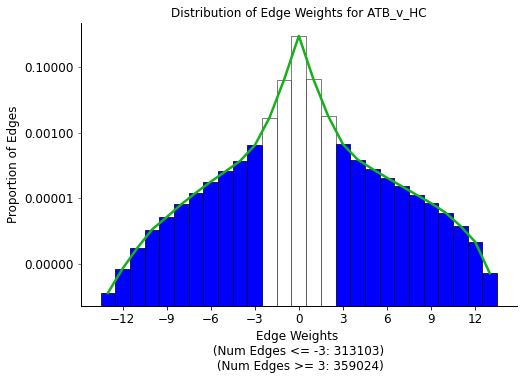

In [15]:
fig , ax = plt.subplots()

plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, f'Distribution of Edge Weights for {comparison_X}', 'xkcd:green')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### minimum/maximum edge weights

In [16]:
np.min(network_edge_weight_matrix)

-13

In [17]:
np.max(network_edge_weight_matrix)

13

## Construct NetworkX graph from edge weight matrix

#### Retrieve the indices for the upper-triangular part of the matrix, normalize edge weights & construct list of edges

Have to (1) retrieve the edges from the upper-triangle of the matrix, (2) convert all to positive edge weights & (3) divide by the number of datasets

In [18]:
#Return the upper triangular part of the matrix with elements in lower part ZEROED out
upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

#Return a boolean for elements in the upper triangular part of the matrix for elments that are <= -3 OR >= 3
upper_tri_network_edge_weight_matrix_bool = abs(upper_tri_network_edge_weight_matrix) >= 3

#get the indices for the elements in the upper triangle where elements (edge weights) <= -3 OR >= 3
node_i_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[0]
node_j_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[1]

#get the normalization factor (number of datasets used to construct edge weights = maximum possible weight)
edge_weight_norm_factor = float(num_datasets_per_comparison[comparison_X])

#Create list of edges for NetworkX graph by iterating through numpy (adjancency) matrix (with edge weights) + node labels (rows/columns of matrix) & storing edges with weights <= -3 OR >= 3
G_edge_list = [ ( network_edge_weight_matrix_labels[node_i], network_edge_weight_matrix_labels[node_j], (float(abs(network_edge_weight_matrix[node_i, node_j]))/edge_weight_norm_factor) ) for node_i, node_j in zip(node_i_indices, node_j_indices)]

In [19]:
G_edge_list[0:10]

[('USB1', 'USB1', 0.3333333333333333),
 ('USB1', 'C12orf57', 0.26666666666666666),
 ('USB1', 'CD6', 0.26666666666666666),
 ('USB1', 'ZNF329', 0.2),
 ('USB1', 'BLVRA', 0.26666666666666666),
 ('USB1', 'CHMP5', 0.2),
 ('USB1', 'P2RY10', 0.2),
 ('USB1', 'TRIM32', 0.2),
 ('USB1', 'BCL3', 0.2),
 ('USB1', 'ACAD11', 0.2)]

In [20]:
len(G_edge_list) #number of edges (gene-gene pairs with edge weights <= -3 OR >= 3)

672127

#### Construct NetworkX graph from list of Edges

In [21]:
G = nx.Graph()
G.add_weighted_edges_from(G_edge_list)

In [22]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3005
Number of edges: 672127
Average degree: 447.3391


Pickle the network for downstream analysis

In [28]:
nx.write_gpickle(G , pickled_objects_dir + f'Network Files/networks/{comparison_X}.pkl')
# use nx.read_gpickle( pickled_objects_dir + f'Network Files/networks/{comparison_X}.pkl') to load

## Visualize network

Use **Spring Layout** to set the positions of the nodes

In [23]:
pos = nx.spring_layout(G , k = 0.35 , weight = 'weight' , iterations = 100)

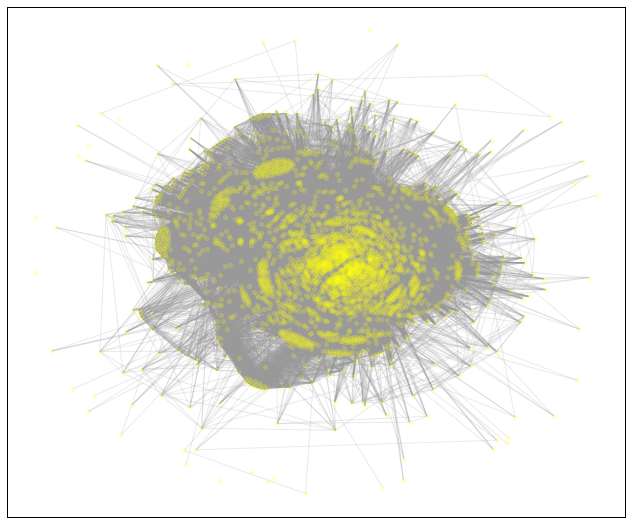

In [24]:
fig , ax = plt.subplots()

nx.draw_networkx(
    G, 
    pos = pos, 
    ax = ax,
    node_size = 20, 
    node_color = 'xkcd:yellow',
    edge_color = "0.6",
    alpha = 0.2, 
    with_labels = False)

fig = plt.gcf()
fig.set_size_inches(9.0, 7.5)
fig.tight_layout()
plt.show()

#### *Function* to color a subset of nodes differently

In [35]:
def draw_graph_and_color_subset_nodes(G, nodes_in_group, ax):

    '''
    This function takes in a graph, list of a subset of nodes and axis object,
    then draws the network with the subset of nodes colored seperately from the 
    rest of the nodes in the network
    '''

    #draw nodes NOT in the (subset) group
    size_map = []
    for node in G:
        if node not in nodes_in_group:
            size_map.append(25)
        elif node in nodes_in_group:
            size_map.append(0)

    nx.draw_networkx(
        G, 
        ax = ax,
        pos=pos, 
        node_size=size_map, 
        node_color = 'xkcd:grey',
        linewidths = 0.0,
        edge_color="0.7",
        width=0.0,
        alpha=0.25, 
        with_labels=False)

    #draw nodes that ARE in the (subset) group
    size_map = []
    for node in G:
        if node not in nodes_in_group:
            size_map.append(0)
        elif node in nodes_in_group:
            size_map.append(25)

    nx.draw_networkx(
        G, 
        pos=pos, 
        ax = ax,
        node_size=size_map, 
        node_color = 'xkcd:black',
        linewidths = 0.0,
        edge_color="0.7",
        width=0.0,
        alpha=0.7, 
        with_labels=False)

## Centrality of Nodes from NetworkX graph

Get a series of the **Degree** for each node

In [36]:
node_list = [node_deg[0] for node_deg in list(G.degree())]
degree_list = [node_deg[1] for node_deg in list(G.degree())]
degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)

Get a series of the **Weighted Degree** for each node

In [37]:
node_list = [node_deg[0] for node_deg in list(G.degree(weight = 'weight'))]
degree_list = [node_deg[1] for node_deg in list(G.degree(weight = 'weight'))]
weighted_degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)

Get a series of the **Eigenvector Centrality** for each node

In [38]:
eigenvector_centrality_series = pd.Series(nx.eigenvector_centrality(G, weight = 'weight')).sort_values(ascending = False) #takes edge weight into account

Pickle **Degree**, **Weighted Degree** and **Eigenvector Centrality** series for comparison with other networks

In [40]:
degree_series.to_pickle(pickled_objects_dir + f'Network Files/degree series/{comparison_X}.pkl')
weighted_degree_series.to_pickle(pickled_objects_dir + f'Network Files/weighted degree series/{comparison_X}.pkl')
eigenvector_centrality_series.to_pickle(pickled_objects_dir + f'Network Files/eigenvector centrality series/{comparison_X}.pkl')

Plot the distibution of **centrality** values for all nodes

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


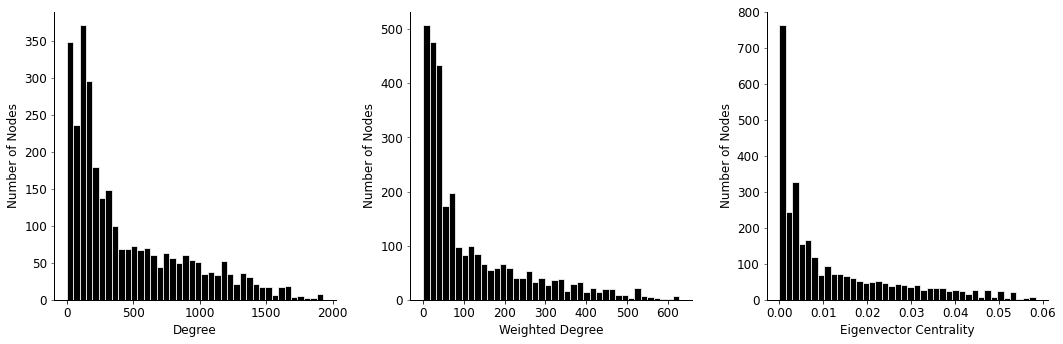

In [41]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

#DEGREE CENTRALITY
ax1.hist(degree_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax1.set_ylabel('Number of Nodes', fontsize = 12, color = 'k')
ax1.set_xlabel(f'Degree' , fontsize = 12, color = 'k')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(False)
ax1.tick_params(labelcolor = 'k')
ax1.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax1.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#WEIGHTED DEGREE CENTRALITY
ax2.hist(weighted_degree_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax2.set_ylabel('Number of Nodes', fontsize = 12, color = 'k')
ax2.set_xlabel(f'Weighted Degree' , fontsize = 12, color = 'k')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.grid(False)
ax2.tick_params(labelcolor = 'k')
ax2.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax2.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
#EIGENVECTOR CENTRALITY
ax3.hist(eigenvector_centrality_series , bins = 40, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax3.set_ylabel('Number of Nodes', fontsize = 12, color = 'k')
ax3.set_xlabel(f'Eigenvector Centrality' , fontsize = 12, color = 'k')

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.grid(False)
ax3.tick_params(labelcolor = 'k')
ax3.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax3.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(15, 5.0)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [43]:
degree_series.head(n=10)

AIM2       1927
SORT1      1927
GBP5       1927
PIK3IP1    1927
SAMD9L     1927
IFITM3     1927
CARD16     1927
ANKRD22    1904
SLC6A12    1874
BATF2      1874
dtype: int64

In [44]:
weighted_degree_series.head(n=10)

SORT1      627.800000
CARD16     627.800000
SAMD9L     627.800000
PIK3IP1    627.800000
IFITM3     627.800000
AIM2       627.800000
GBP5       627.800000
ANKRD22    604.800000
BATF2      583.066667
SLC6A12    583.066667
dtype: float64

In [45]:
eigenvector_centrality_series.head(n=10)

GBP5       0.058306
AIM2       0.058306
SAMD9L     0.058306
CARD16     0.058306
SORT1      0.058306
IFITM3     0.058306
PIK3IP1    0.058306
ANKRD22    0.055686
TLR5       0.055415
GBP2       0.055415
dtype: float64

How does the ranking of centrality values between **Weighted Degree** and **Eigenvector** centrality compare?

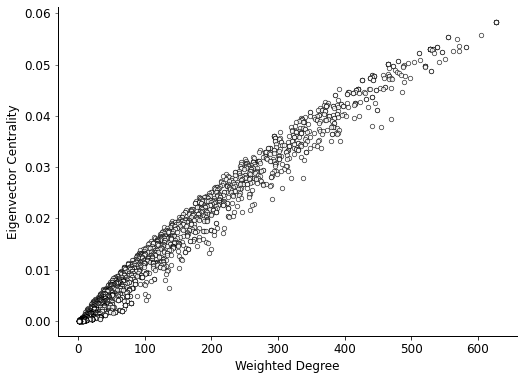

In [46]:
fig , ax = plt.subplots()

ax.scatter(weighted_degree_series[eigenvector_centrality_series.index], eigenvector_centrality_series , color = 'white' , linewidth=0.75 , edgecolor = 'black' , s = 20 , alpha = 0.75)

#ax.set_title('Degree vs. Eigenvector Centrality', fontsize = 10, color = 'k')
ax.set_ylabel('Eigenvector Centrality', fontsize = 12, color = 'k')
ax.set_xlabel('Weighted Degree' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [47]:
for edge in weighted_degree_series.head(n=10).index:
    print(edge)

SORT1
CARD16
SAMD9L
PIK3IP1
IFITM3
AIM2
GBP5
ANKRD22
BATF2
SLC6A12


Where are the most **central** nodes located in the network?

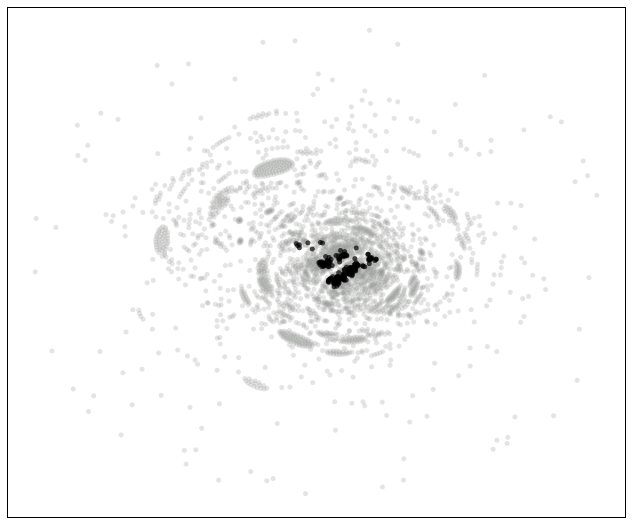

In [49]:
central_nodes = set(weighted_degree_series[0:200].index)

fig , ax = plt.subplots()

draw_graph_and_color_subset_nodes(G, central_nodes, ax)

fig = plt.gcf()
fig.set_size_inches(9.0, 7.5)
fig.tight_layout()
plt.show()

## Analyze Transcription Factors

Load list of transcription factors from CSV file

In [50]:
TF_df = pd.read_csv("/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Transcription Factor list/DatabaseExtract_v_1.01.csv").set_index('Unnamed: 0')

In [51]:
TF_df.head()

,Ensembl ID,HGNC symbol,DBD,Is TF?,TF assessment,Binding mode,Motif status,Final Notes,Final Comments,Interpro ID(s),...,CisBP considers it a TF?,TFCat classification,Is a GO TF?,Initial assessment,Curator 1,Curator 2,TFclass considers it a TF?,Go Evidence,Pfam Domains (By ENSP ID),Is C2H2 ZF(KRAB)?
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,ENSG00000137203,TFAP2A,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR008121;IPR013854,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Yimeng Yin,Yes,$#ENSG00000137203#GO:0000981#sequence-specific...,$#ENSP00000368928#ENSG00000137203#ENST00000379...,False
1,ENSG00000008196,TFAP2B,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR008122;IPR013854,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Matt Weirauch,Yimeng Yin,Yes,$#ENSG00000008196#GO:0000981#sequence-specific...,$#ENSP00000377265#ENSG00000008196#ENST00000393...,False
2,ENSG00000087510,TFAP2C,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR008123;IPR013854,...,Yes,No,Yes,"1a1, Direct HQ evidence",Matt Weirauch,Yimeng Yin,Yes,$#ENSG00000087510#GO:0001077#RNA polymerase II...,$#ENSP00000201031#ENSG00000087510#ENST00000201...,False
3,ENSG00000008197,TFAP2D,AP-2,Yes,Known motif,Monomer or homomultimer,In vivo/Misc source,Only known motifs are from Transfac or HocoMoc...,Binds the same GCCTGAGGC sequence as the other...,IPR013854;,...,Yes,No,Yes,"2a1, Lower confidence direct evidence",Arttu Jolma,Sam Lambert,Yes,$#ENSG00000008197#GO:0000981#sequence-specific...,$#ENSP00000008391#ENSG00000008197#ENST00000008...,False
4,ENSG00000116819,TFAP2E,AP-2,Yes,Known motif,Monomer or homomultimer,High-throughput in vitro,None,None,IPR013854;,...,Yes,TF Gene_DNA-Binding: sequence-specific_DNA Bin...,Yes,"1a1, Direct HQ evidence",Sam Lambert,Laura Campitelli,Yes,$#ENSG00000116819#GO:0000981#sequence-specific...,$#ENSP00000362332#ENSG00000116819#ENST00000373...,False


In [52]:
np.shape(TF_df)

(2765, 28)

Keep only the genes from list that are Transcription Factors

In [53]:
TF_df = TF_df[TF_df.loc[: , 'Is TF?'] == 'Yes']
TF_df.reset_index(inplace = True , drop = True)

In [54]:
np.shape(TF_df)

(1639, 28)

Get list of TFs using the HGNC gene symbols

In [55]:
TF_list = list(TF_df.loc[: , 'HGNC symbol'])

In [56]:
len(TF_list)

1639

#### Get the weighted degree for the transcription factors that are present in nodes in the graph

In [57]:
TF_node_gene_list = []
TF_node_weighted_degree_list = []

gene_nodes_in_G = set(weighted_degree_series.index)

for gene_i in TF_list:
    
    if gene_i in gene_nodes_in_G:
        
        TF_node_gene_list.append(gene_i)
        TF_node_weighted_degree_list.append(weighted_degree_series[gene_i])
        
TF_weighted_degree_series = pd.Series(TF_node_weighted_degree_list, index = TF_node_gene_list).sort_values(ascending = False)

In [58]:
TF_weighted_degree_series.head(n=20)

BATF2     583.066667
STAT1     527.866667
ZNF91     480.200000
ZNF438    465.666667
TRAFD1    443.866667
PLSCR1    441.866667
ETV7      438.266667
LEF1      416.666667
ETS1      390.666667
ZNF827    375.466667
ZNF395    375.400000
STAT2     371.533333
ZNF831    362.333333
ZNF256    356.000000
OLIG1     353.533333
ZNF529    339.933333
IRF1      337.333333
KLF12     323.933333
LTF       316.800000
SPIB      311.800000
dtype: float64

In [59]:
len(TF_weighted_degree_series)

281

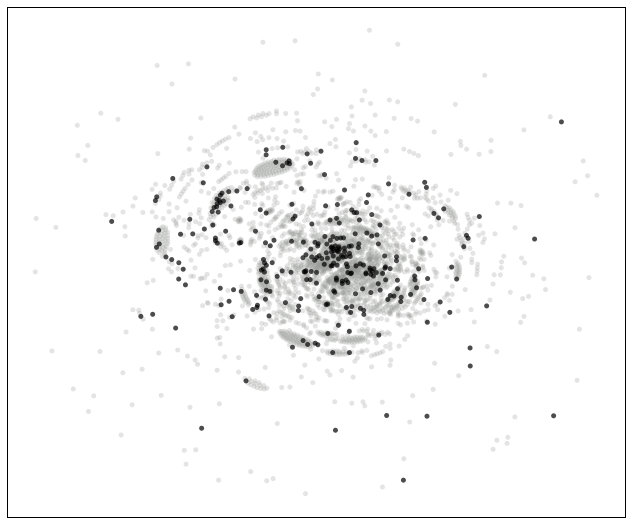

In [60]:
fig , ax = plt.subplots()

draw_graph_and_color_subset_nodes(G, list(TF_weighted_degree_series.index), ax)

fig = plt.gcf()
fig.set_size_inches(9.0, 7.5)
fig.tight_layout()
plt.show()

#### plot the distribution of centrality for nodes in the network that are transcription factors

In [61]:
weighted_degree_TF_thresh = 300

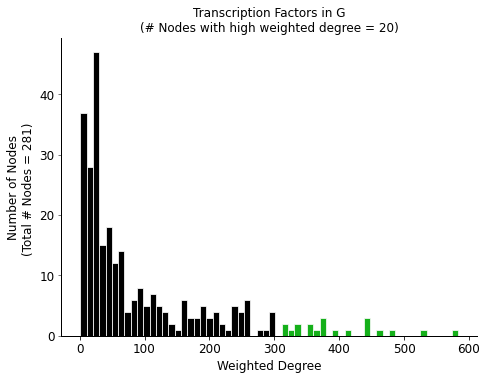

In [62]:
fig , ax = plt.subplots()

n, bins, patches = ax.hist(TF_weighted_degree_series , bins = 60, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)
ax.hist(TF_weighted_degree_series[TF_weighted_degree_series >= weighted_degree_TF_thresh] , bins = bins, color = 'xkcd:green' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax.set_title(f'Transcription Factors in G\n(# Nodes with high weighted degree = {len(TF_weighted_degree_series[TF_weighted_degree_series >= weighted_degree_TF_thresh].index)})', fontsize = 12, color = 'k')
ax.set_ylabel(f'Number of Nodes\n(Total # Nodes = {len(TF_weighted_degree_series.index)}) ', fontsize = 12, color = 'k')
ax.set_xlabel('Weighted Degree' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.0, 5.5)
fig.tight_layout()

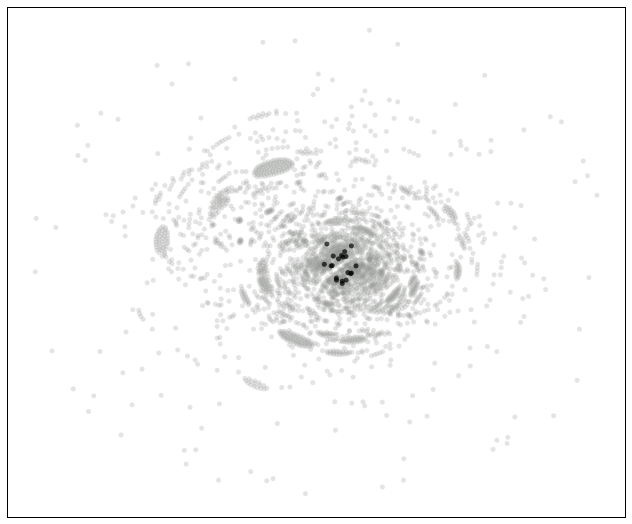

In [63]:
fig , ax = plt.subplots()

draw_graph_and_color_subset_nodes(G, list(TF_weighted_degree_series[TF_weighted_degree_series >= weighted_degree_TF_thresh].index), ax)

fig = plt.gcf()
fig.set_size_inches(9.0, 7.5)
fig.tight_layout()
plt.show()

In [64]:
for gene_i in TF_weighted_degree_series[TF_weighted_degree_series >= weighted_degree_TF_thresh].index:
    print(gene_i)

BATF2
STAT1
ZNF91
ZNF438
TRAFD1
PLSCR1
ETV7
LEF1
ETS1
ZNF827
ZNF395
STAT2
ZNF831
ZNF256
OLIG1
ZNF529
IRF1
KLF12
LTF
SPIB


In [65]:
TF_weighted_degree_series.head(n=40)

BATF2      583.066667
STAT1      527.866667
ZNF91      480.200000
ZNF438     465.666667
TRAFD1     443.866667
PLSCR1     441.866667
ETV7       438.266667
LEF1       416.666667
ETS1       390.666667
ZNF827     375.466667
ZNF395     375.400000
STAT2      371.533333
ZNF831     362.333333
ZNF256     356.000000
OLIG1      353.533333
ZNF529     339.933333
IRF1       337.333333
KLF12      323.933333
LTF        316.800000
SPIB       311.800000
ZSCAN18    299.400000
CREB5      298.733333
MAFB       295.466667
IRF7       294.400000
RBCK1      291.200000
GATA3      277.000000
ZNF439     262.866667
ZNF30      262.866667
TSHZ3      261.400000
PBX4       257.133333
ATF3       253.533333
SP140      253.466667
BCL6       250.666667
ZNF248     246.533333
STAT4      245.600000
SOX8       244.400000
ZNF548     243.133333
ZNF540     241.933333
SATB1      240.666667
HSF2       234.600000
dtype: float64

## Get mean $log_2$(Fold Change) for all genes in network

Create a series that stores the mean $log2(FC)$ across datasets from the $log2(FC)$ matrix (rows = genes & columns = datasets)

when averaging $log2(FC)$ across datasets, **only include the non-zero** datasets (columns)???

- datasets in which logFC for a gene = 0 are due to q-value threshold or logFC threshold???

In [101]:
genes_in_network = list(G.nodes()) #get all nodes in the network
mean_logFC_series = pd.Series(index = genes_in_network) #create series

for gene_i in mean_logFC_series.index:
    
    #use code below to calculate average logFC for gene across datasets (ignoring the entries where logFC = 0)
    #gene_i_mean_logFC = float(diff_gene_exp_df.loc[gene_i , :].sum()) / float(np.sum(diff_gene_exp_df.loc[gene_i , :] != 0.0))
    
    #use code below to calculate average logFC for gene across ALL datasets/studies
    gene_i_mean_logFC = diff_gene_exp_df.loc[gene_i , :].mean()
    
    #append to series
    mean_logFC_series[gene_i] = gene_i_mean_logFC
    
mean_logFC_series.sort_values(inplace = True, ascending = False)

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [102]:
mean_logFC_series.head(n = 15)

SERPING1    2.805312
ANKRD22     2.713292
BATF2       2.319556
P2RY14      2.241647
FCGR1B      2.127004
FCGR1A      1.970703
C1QB        1.948871
GBP5        1.808402
EPSTI1      1.801306
IFITM3      1.698333
CARD17      1.678478
GBP1P1      1.664486
AIM2        1.649580
RTP4        1.606128
GBP1        1.594928
dtype: float64

In [103]:
mean_logFC_series.tail(n = 15)

OLR1      -0.830470
SPOCK2    -0.832186
PIK3IP1   -0.833861
FLNB      -0.844765
CXCR5     -0.855985
TSEN54    -0.863101
EPHA4     -0.979234
FAM102A   -0.979361
TMEM204   -0.992089
DHRS3     -1.022145
LRRN3     -1.030773
PASK      -1.152869
ID3       -1.170676
CCR7      -1.201009
NELL2     -1.273472
dtype: float64

In [104]:
np.shape(mean_logFC_series)

(3005,)

#### plot the distribution of mean logFC for genes (nodes) in the network

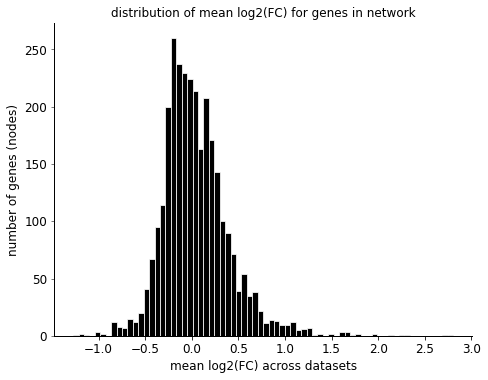

In [107]:
fig , ax = plt.subplots()

n, bins, patches = ax.hist(mean_logFC_series , bins = 70, color = 'black' , rwidth = 1.0 , edgecolor='white', linewidth=0.75)

ax.set_title(f'distribution of mean log2(FC) for genes in network', fontsize = 12, color = 'k')
ax.set_ylabel(f'number of genes (nodes)', fontsize = 12, color = 'k')
ax.set_xlabel('mean log2(FC) across datasets' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.0, 5.5)
fig.tight_layout()

Pickle **mean $log2(FC)$** series for comparison with other networks and downstream analysis

In [108]:
mean_logFC_series.to_pickle(pickled_objects_dir + f'Network Files/mean logFC network nodes series/{comparison_X}.pkl')